In [1]:
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score,recall_score,precision_score
from os import listdir
from os.path import isfile, join,isdir
import os
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})

In [2]:
scores = {
    'f1':f1_score,
    'recall':recall_score,
    'precision':precision_score
}

In [33]:
def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)
def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))

def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb




def getTypesListCombinationfromPath(model_obj_path,gt_test,gt_train):
    models_dict = pickle.load(open( model_obj_path, "rb" ) )
    predicted_test =  models_dict['predicted_test']
    predicted_train =  models_dict['predicted_train']
    max_fragment_len = models_dict['max_fragment_len']
    inv_types_map = models_dict['inv_types_map']
    try:
        predicted_test = de_flattenData(predicted_test,max_fragment_len)
        predicted_train = de_flattenData(predicted_train,max_fragment_len)
    except:
        pass
    pred_list_test = getTypesListCombination(predicted_test,inv_types_map)
    pred_list_test = deletePadding(pred_list_test,gt_test)
    pred_list_test_flat = reduce(lambda x,y: x+y,pred_list_test)
    pred_list_train= getTypesListCombination(predicted_train,inv_types_map)
    pred_list_train = deletePadding(pred_list_train,gt_train)
    pred_list_train_flat = reduce(lambda x,y: x+y,pred_list_train)
    return pred_list_test,pred_list_train,pred_list_test_flat,pred_list_train_flat

def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getOffsetListGT(groundtruth_paths):
    offset_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        offsets = [r['continue'] for r in recs_gt]
        offset_df_per_file.append(offsets)
    return offset_df_per_file

def getTextList(groundtruth_paths):
    text_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        texts = list()
        for r in recs_gt:
            text = r['text']
            texts.append(text)
        text_df_per_file.append(texts)
    return text_df_per_file

def getTypeExtractor(ext,features_paths,flatten=False):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    if flatten:
        type_df_per_file = reduce(lambda x,y: x+y,type_df_per_file)
    return type_df_per_file


def getHistoryGraph(model_obj_path,saving_path=None):
    models_dict = pickle.load(open( model_obj_path, "rb" ) )
    
    history_df = pd.DataFrame(models_dict['history_scores'])
    history_df_cols = list(history_df.columns)
    history_df_cols.sort()
    measures_values = {m:list(history_df[m]) for m in list(history_df.columns) if m in ['loss','val_loss']}

    fig = plt.figure(figsize=(15,8))
    for m in measures_values:
        plt.plot(measures_values[m], label=m)
    
    plt.legend()
    plt.xlabel('epochs')
    if bool(saving_path):
        plt.savefig(saving_path+'_loss.png')
    plt.show()
    plt.close()
    
    measures_values = {m:list(history_df[m]) for m in list(history_df.columns) if m not in ['loss','val_loss']}
    fig = plt.figure(figsize=(15,8))
    for m in measures_values:
        plt.plot(measures_values[m], label=m)
    
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('f1_score')
    if bool(saving_path):
        plt.savefig(saving_path+'_f1.png')
    plt.show()
    
def getScores(gt_list,p_list,scores,types):
    score_O2 = {t:{'extractor':t} for t in types}
    score_obj= dict()
    for score in scores:
        scores_res = scores[score](gt_list, p_list, labels=types,average=None)
        for i,t in enumerate(types):
            score_obj[score+' '+t]=scores_res[i]
            score_O2[t][score] = scores_res[i]
        for avg in ['micro', 'macro']:
            sc = scores[score](gt_list, p_list, labels=types,average=avg)
            score_obj[score+' '+avg]=sc
            score_O2[t][score] = sc
    score_records = [score_O2[key] for key in score_O2]
    df_eval_extractor = pd.DataFrame(score_records)
    return score_obj,df_eval_extractor


def generateHistogram(x,path,ext_names):
    N = len(x)
    x = np.transpose(x)
    f1_score = tuple(x[0])
    precision = tuple(x[1])
    recall = tuple(x[2])


    ind = np.arange(N)  # the x locations for the groups
    width = 0.3      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))

    rects1 = ax.bar(ind, f1_score, width, color='r')

    rects2 = ax.bar(ind + width, precision, width, color='y')

    rects3 = ax.bar(ind + width*2, recall, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by extractor')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(tuple(ext_names+['combination']))

    ax.legend((rects1[0], rects2[0],rects3[0]), ('F1_score', 'Precision','Recall'))


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '',
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.savefig(path, dpi=600)
    plt.show()
    
def evaluate(evaluation_obj,scores,types,gt_true,evaluation_folder):
    evaluation_records = list() 
    for key in evaluation_obj:
        if 'output' in evaluation_obj[key] and set(evaluation_obj[key]['output']) == set(gt_true):
            score_obj,df_eval_extr= getScores(gt_true,evaluation_obj[key]['output'],scores,types)
        else:
            score_obj,df_eval_extr= getScores(gt_true,evaluation_obj[key]['predicted'],scores,types)
        writer = pd.ExcelWriter(evaluation_folder+key+'scores.xlsx')
        df_eval_extr.to_excel(writer)
        writer.save()
        rec = deepcopy(score_obj)
        rec['extracor'] = key
        evaluation_records.append(rec)
    evaluation_df = pd.DataFrame(evaluation_records)
    writer_1 = pd.ExcelWriter(evaluation_folder+'scores.xlsx')
    evaluation_df.to_excel(writer_1)
    writer_1.save()
    evaluation_folder_hist = evaluation_folder+'hist/'
    try:
        os.makedirs(evaluation_folder_hist)
    except:
        pass
    ext_names = list(evaluation_df['extracor'])
    for mes in types + ['micro', 'macro', 'weighted']:
        x = list()
        for ext in ext_names: 
            x.append([list(evaluation_df[evaluation_df['extracor']==ext][root+mes])[0] for root in ['f1 ','precision ','recall ']])
        generateHistogram(x,evaluation_folder_hist+mes+'.png',ext_names)
    
    best_obj = {mes:ext_names[evaluation_df[mes].argmax()] for mes in set(evaluation_df.columns) - {'extracor'}}
    with open(evaluation_folder+'best_obj.json', 'w') as outfile:
        json.dump(best_obj, outfile)
    return evaluation_df

def setName(name):
    if name[0].isdigit():
        name = 'COMBINED '+name
    return name

def create_excel(eval_obj,texts,groundtruth_paths,gt_list,path):
    texts_flatten = reduce(lambda x,y: x+y,texts)
    writer = pd.ExcelWriter(path)
    fragments = [g.split('/')[-1].split('.')[0] for g in groundtruth_paths]
    file_len = [len(t) for t in texts]
    records_all = list()
    i = 0
    for k,l in enumerate(file_len):
        records = list()
        for j in range(l):
            obj = dict()
            for key in eval_obj:
                obj[setName(key+' predicted')] = eval_obj[key]['predicted'][i]
                if 'output' in eval_obj[key]:
                    obj[key+' output'] = eval_obj[key]['output'][i]
            obj['1_TEXT_'] = texts_flatten[i]
            obj['2_GROUND TRUTH_'] = gt_list[i]
            records.append(obj)
            records_all.append(obj)
            i+=1
        df = pd.DataFrame(records)
        df.to_excel(writer,fragments[k])
    writer.save()
    df = pd.DataFrame(records_all)
    return df

In [4]:
base = 'OKE2016'
extractors_types=['alchemy', 'adel', 'opencalais','dandelion', 'dbspotlight', 'babelfy', 'textrazor','meaning_cloud']

In [5]:
training_folder = 'training_data/'+base+'/'
evaluation_folder = training_folder+'evaluation/'
try:
    os.makedirs(evaluation_folder)
except:
    pass
folder_to_evaluate = training_folder+'models/'
combine_folder = folder_to_evaluate + 'combined/'

ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

text_folder_train = training_folder + 'train/txt_files/'
text_folder_test = training_folder + 'test/txt_files/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()
features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()

texts_paths_train = [path.replace(features_folder_train,text_folder_train).replace('.p','.txt') for path in features_paths_train]
texts_paths_train.sort()
texts_paths_test = [path.replace(features_folder_test,text_folder_test).replace('.p','.txt') for path in features_paths_test]
texts_paths_test.sort()


types = set()
for g in groundtruth_paths_train+groundtruth_paths_test:
    truth_pd = pd.read_csv(g)
    types = types | set(truth_pd['type'])

types.remove(np.NAN)
types = list(types)
types.sort()

combined_names = [f for f in listdir(combine_folder) if isdir(join(combine_folder, f))]


evaluation_obj = {
    'test':{ext:dict() for ext in extractors_types+combined_names},
    'train':{ext:dict() for ext in extractors_types+combined_names}
}

gt_test = getTypesListGT(groundtruth_paths_test)
gt_test_flatten = reduce(lambda x,y: x+y,gt_test)

gt_test_offset = getOffsetListGT(groundtruth_paths_test)
gt_test_offset_flatten = reduce(lambda x,y: x+y,gt_test_offset)

gt_train = getTypesListGT(groundtruth_paths_train)
gt_train_flatten = reduce(lambda x,y: x+y,gt_train)

gt_train_offset = getOffsetListGT(groundtruth_paths_train)
gt_train_offset_flatten = reduce(lambda x,y: x+y,gt_train_offset)

texts_test = getTextList(groundtruth_paths_test)
texts_flatten_test = reduce(lambda x,y: x+y,texts_test)

texts_train = getTextList(groundtruth_paths_train)
texts_flatten_train = reduce(lambda x,y: x+y,texts_train)

In [6]:
for ext in extractors_types:
    model_obj_path = folder_to_evaluate+'type/'+ext+'/model_obj.p'
    pred_list_test_xfile,pred_list_train_xfile,pred_list_test,pred_list_train = getTypesListCombinationfromPath(model_obj_path,gt_test,gt_train)
    evaluation_obj['test'][ext]['predicted'] = pred_list_test
    evaluation_obj['train'][ext]['predicted'] = pred_list_train
    evaluation_obj['test'][ext]['predicted_per_file'] = pred_list_test_xfile
    evaluation_obj['train'][ext]['predicted_per_file'] = pred_list_train_xfile
    try:
        evaluation_obj['test'][ext]['output'] = getTypeExtractor(ext,features_paths_test,flatten=True)
        evaluation_obj['train'][ext]['output'] = getTypeExtractor(ext,features_paths_train,flatten=True)
    except:
        pass
    

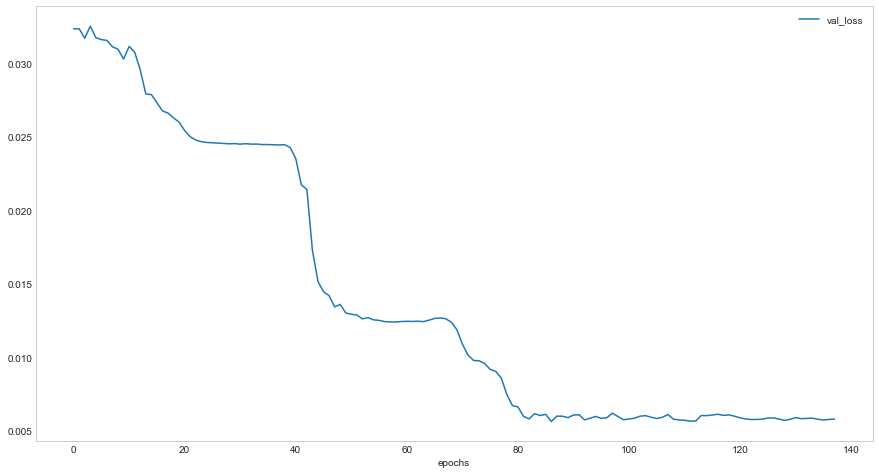

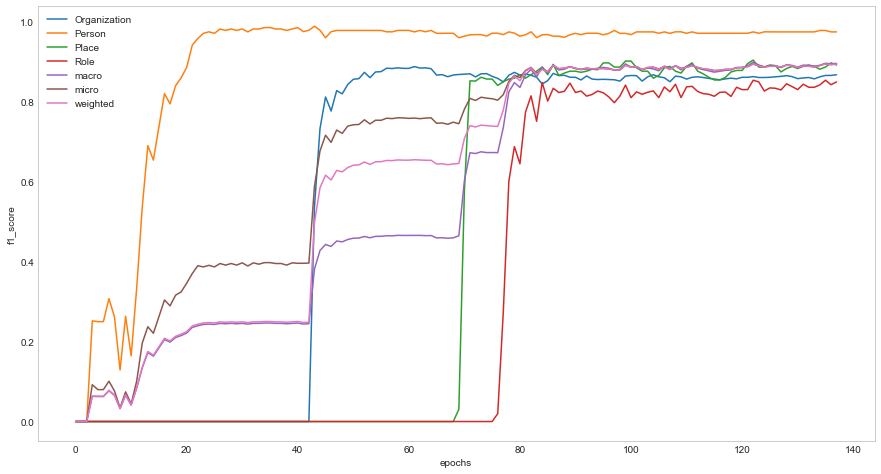

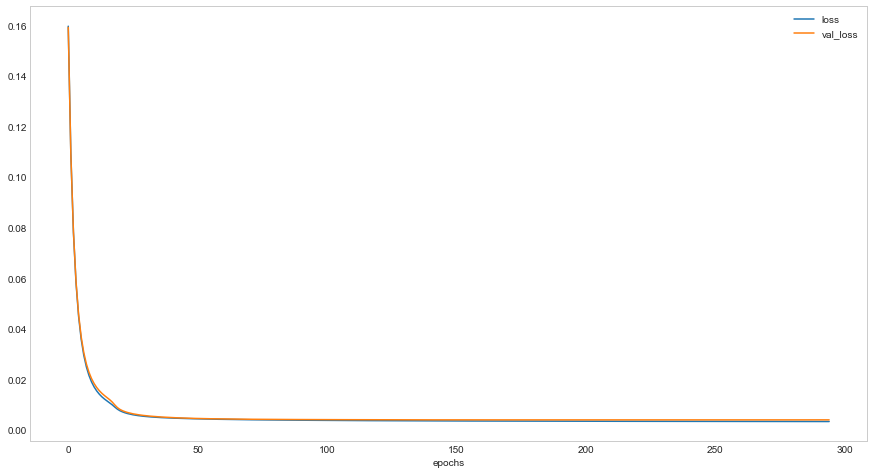

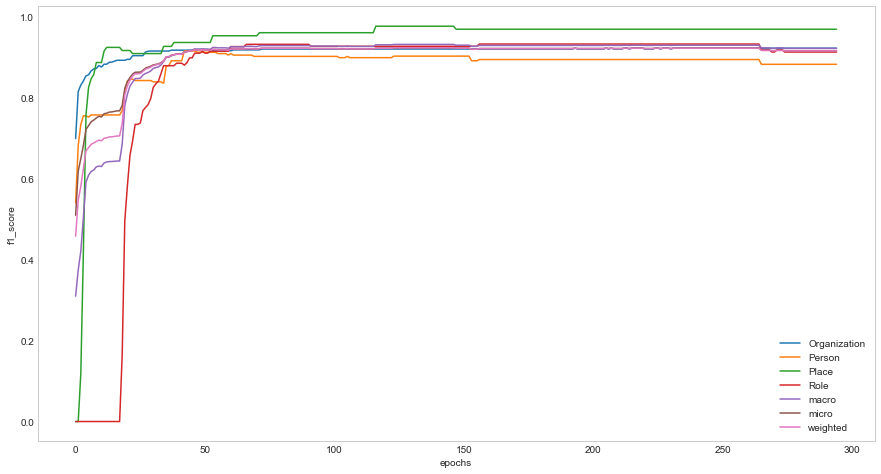

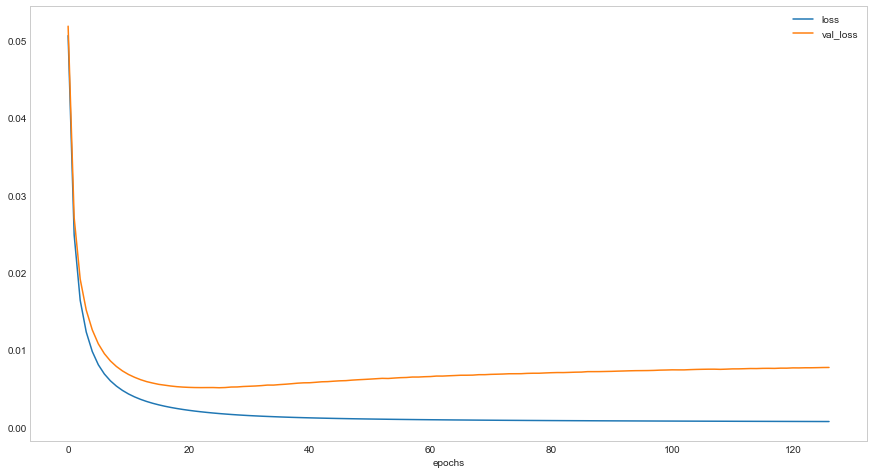

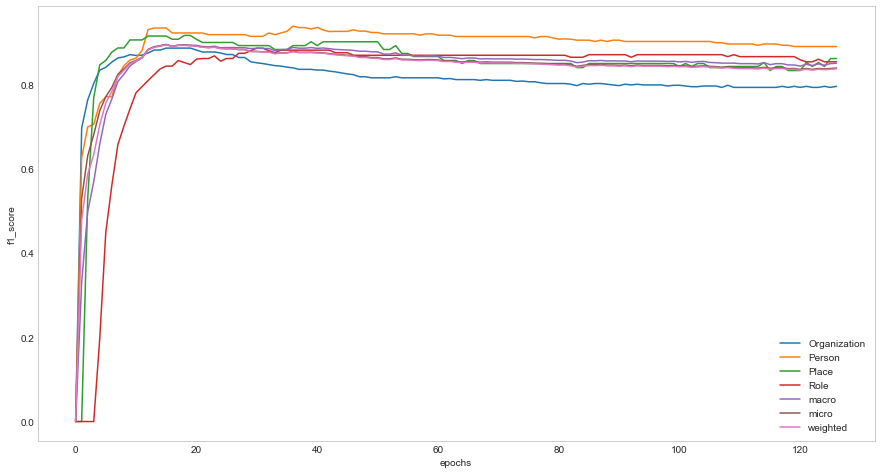

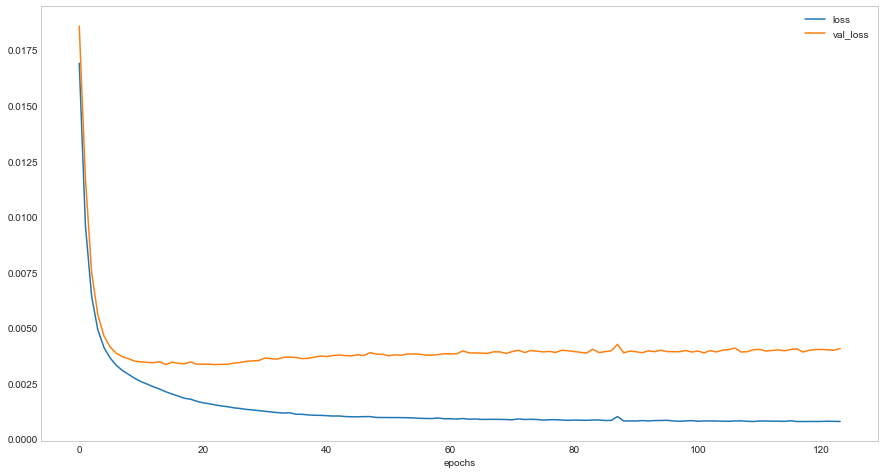

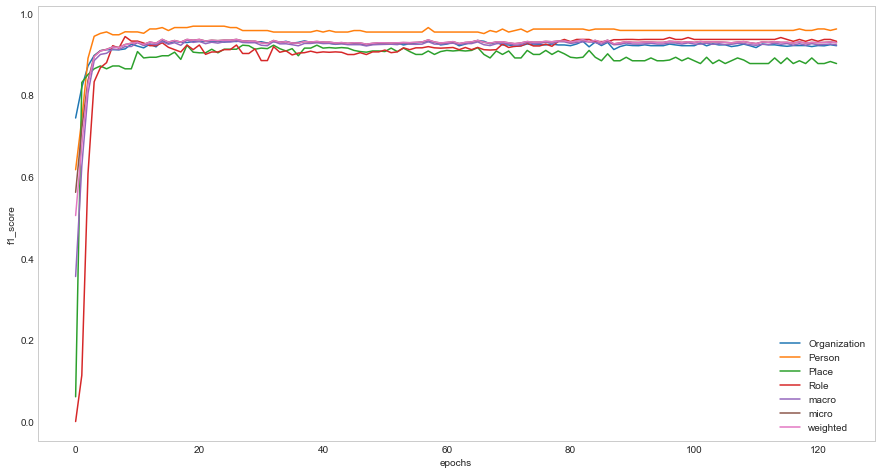

In [9]:
for f in combined_names:
    model_obj_path = combine_folder+f+'/model_obj.p'
    pred_list_test_xfile,pred_list_train_xfile,pred_list_test,pred_list_train = getTypesListCombinationfromPath(model_obj_path,gt_test,gt_train)
    evaluation_obj['test'][f]['predicted'] = pred_list_test
    evaluation_obj['train'][f]['predicted'] = pred_list_train
    evaluation_obj['test'][f]['predicted_per_file'] = pred_list_test_xfile
    evaluation_obj['train'][f]['predicted_per_file'] = pred_list_train_xfile
    saving_figure_path = combine_folder+f+'/learning_history'
    getHistoryGraph(model_obj_path,saving_path=saving_figure_path)

In [ ]:
evaluation_obj['test']['alchemy']['output']

In [10]:
df1 =create_excel(evaluation_obj['test'],texts_test,groundtruth_paths_test,gt_test_flatten,evaluation_folder + 'test.xlsx')

In [30]:
print(list(df1.columns))

['1_TEXT_', '2_GROUND TRUTH_', 'COMBINED 0 predicted', 'COMBINED 1 predicted', 'COMBINED 2 predicted', 'COMBINED 3 predicted', 'adel output', 'adel predicted', 'alchemy output', 'alchemy predicted', 'babelfy predicted', 'dandelion predicted', 'dbspotlight predicted', 'opencalais output', 'opencalais predicted', 'textrazor output', 'textrazor predicted']


In [ ]:
['1_TEXT_', '2_GROUND TRUTH_', 'COMBINED 3 predicted', 'adel output', 'alchemy output', 'babelfy predicted', 'dandelion predicted', 'dbspotlight predicted','opencalais output','textrazor output']

In [34]:
writer = pd.ExcelWriter('adel_mistakes.xlsx')
df = df1[['1_TEXT_', '2_GROUND TRUTH_', 'COMBINED 3 predicted', 'adel output', 'alchemy output', 'babelfy predicted', 'dandelion predicted', 'dbspotlight predicted','opencalais output','textrazor output']]
df[(df['COMBINED 3 predicted']==df['2_GROUND TRUTH_'])&(df['2_GROUND TRUTH_']!=df['adel output'])].to_excel(writer)
writer.save()

In [21]:
writer = pd.ExcelWriter('alchemy_mapping.xlsx')
df = df1[['1_TEXT_','alchemy output','alchemy predicted']]

df[df['alchemy output']!='0'].to_excel(writer)
writer.save()

In [260]:
df2 = create_excel(evaluation_obj['train'],texts_train,groundtruth_paths_train,gt_train_flatten,evaluation_folder + 'train.xlsx')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


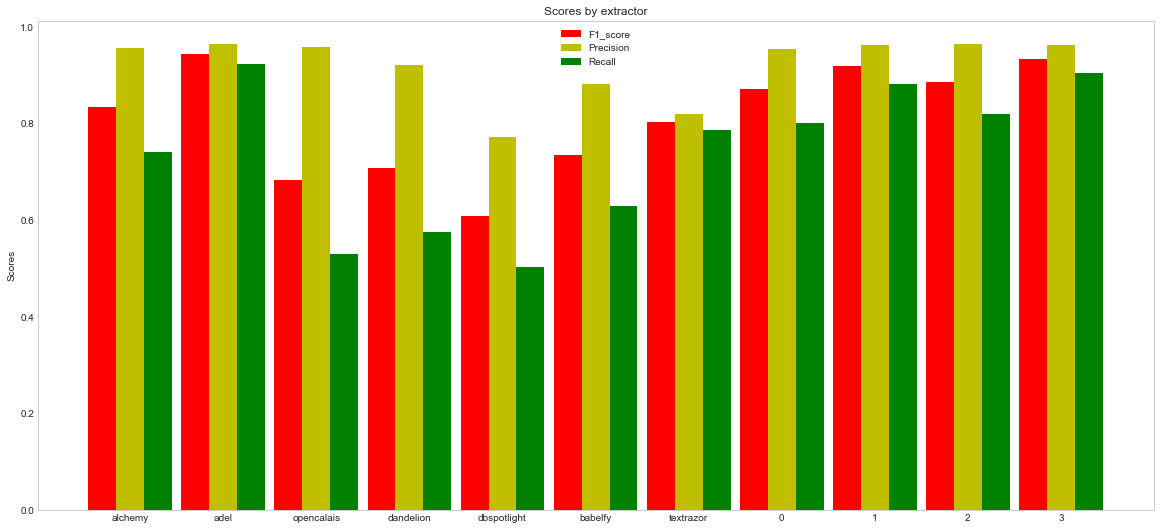

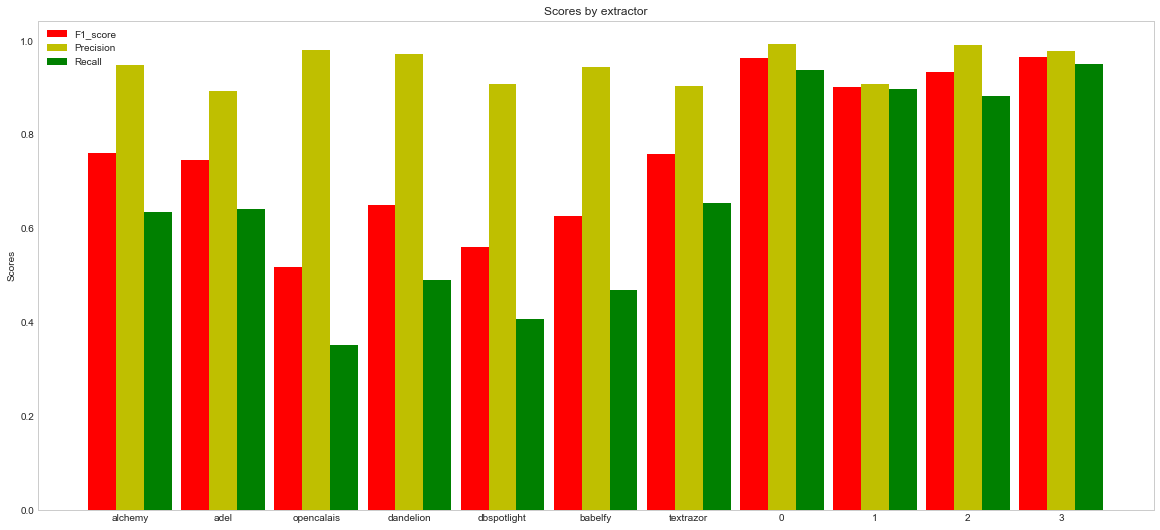

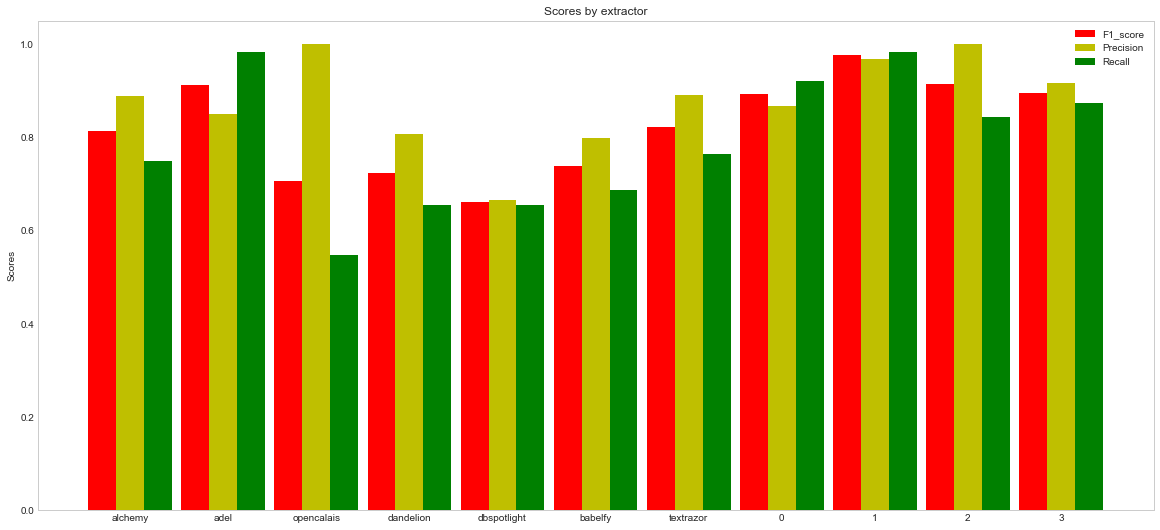

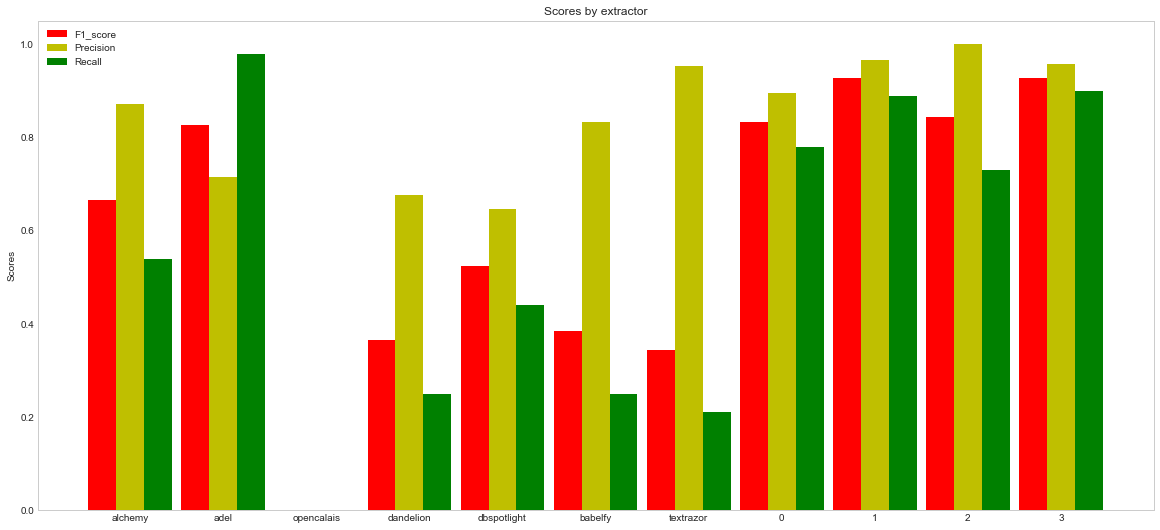

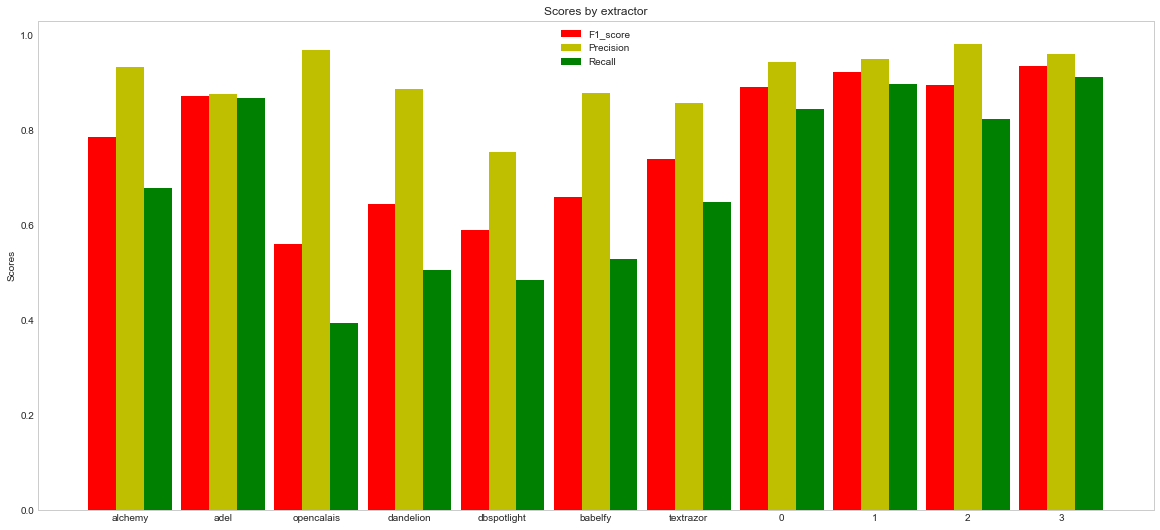

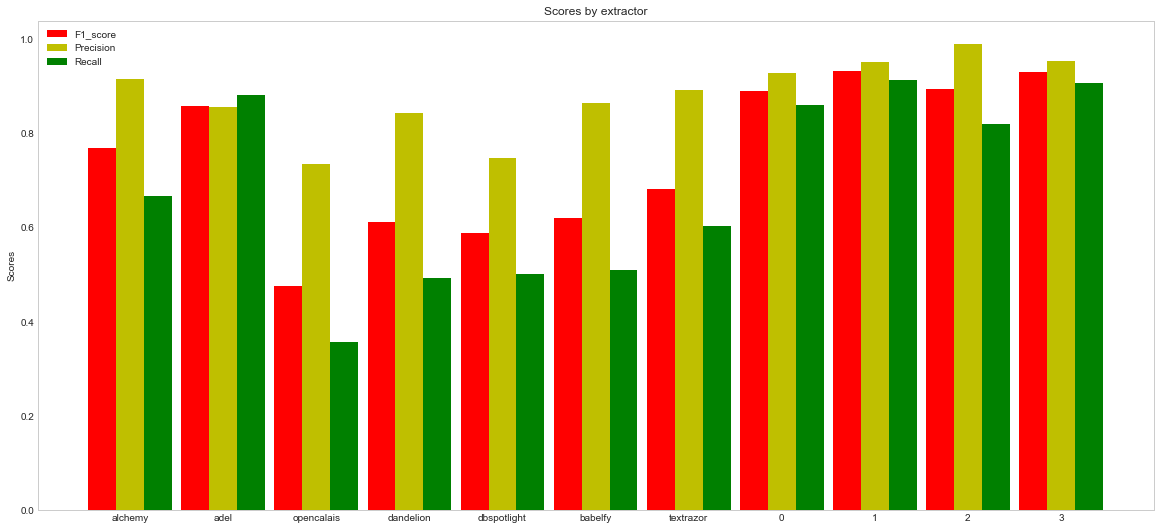

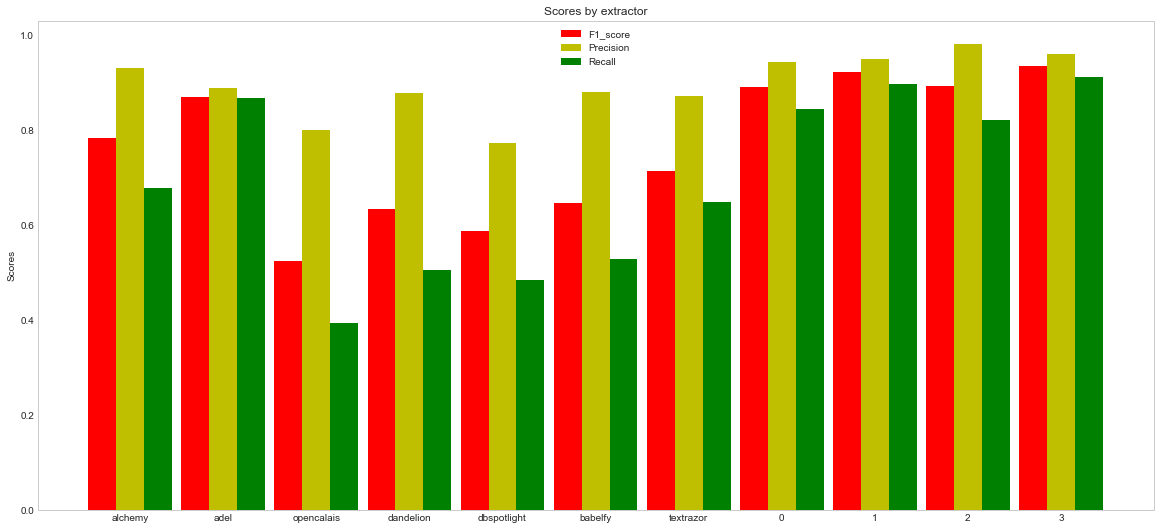

In [261]:
evaluation_df_test= evaluate(evaluation_obj['test'],scores,types,gt_test_flatten,evaluation_folder+'test_')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


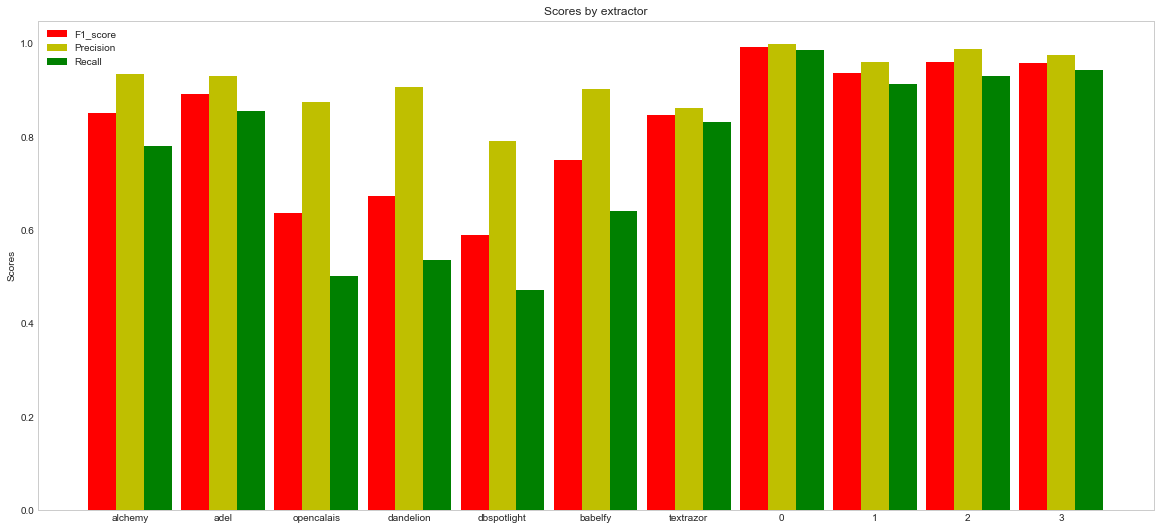

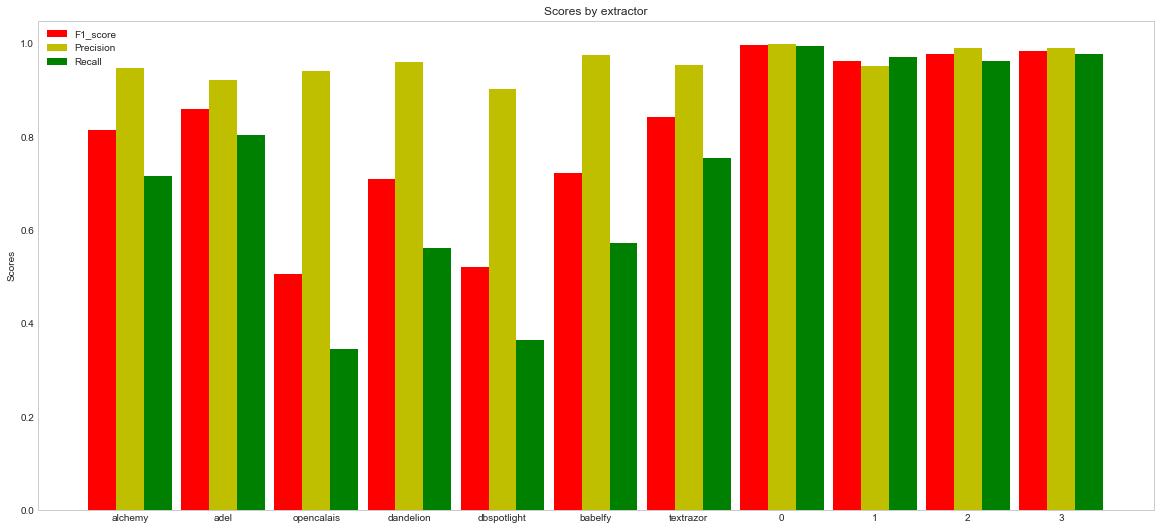

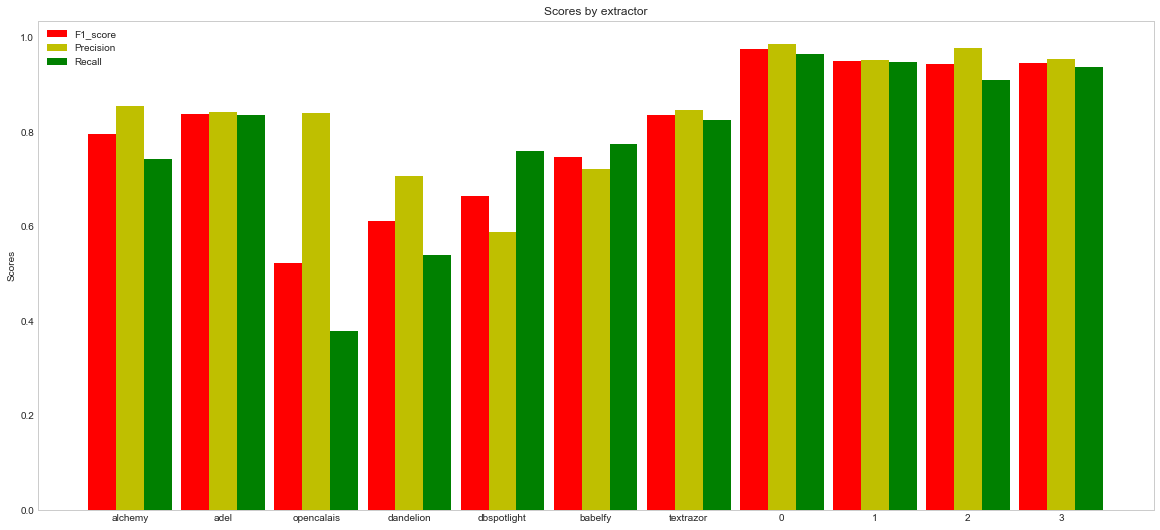

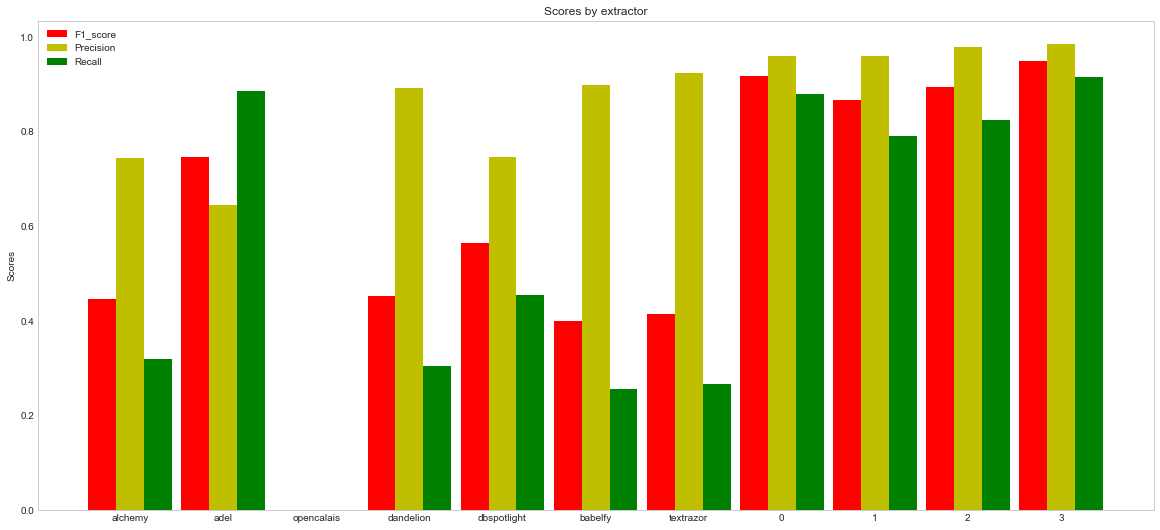

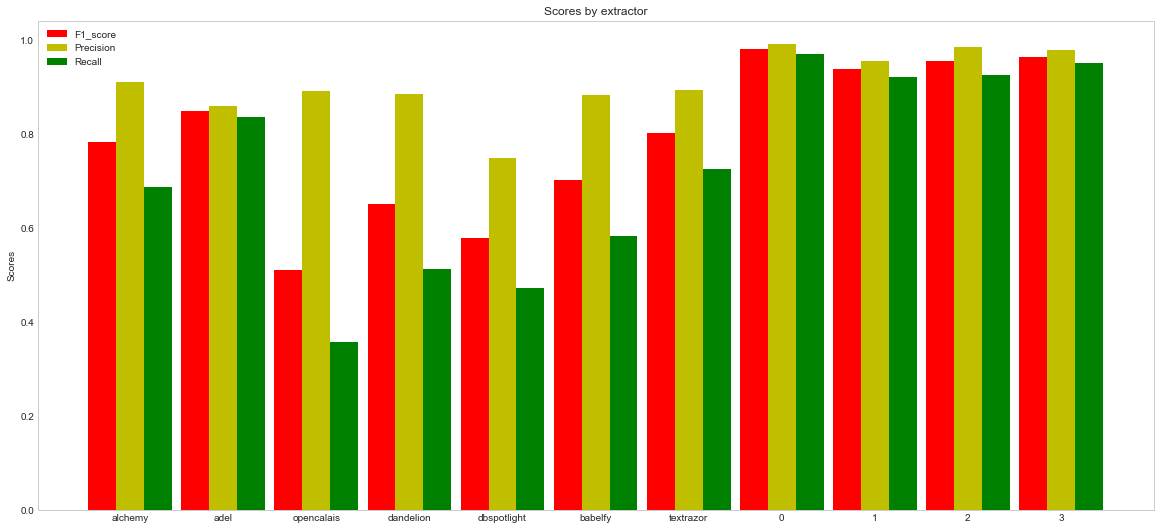

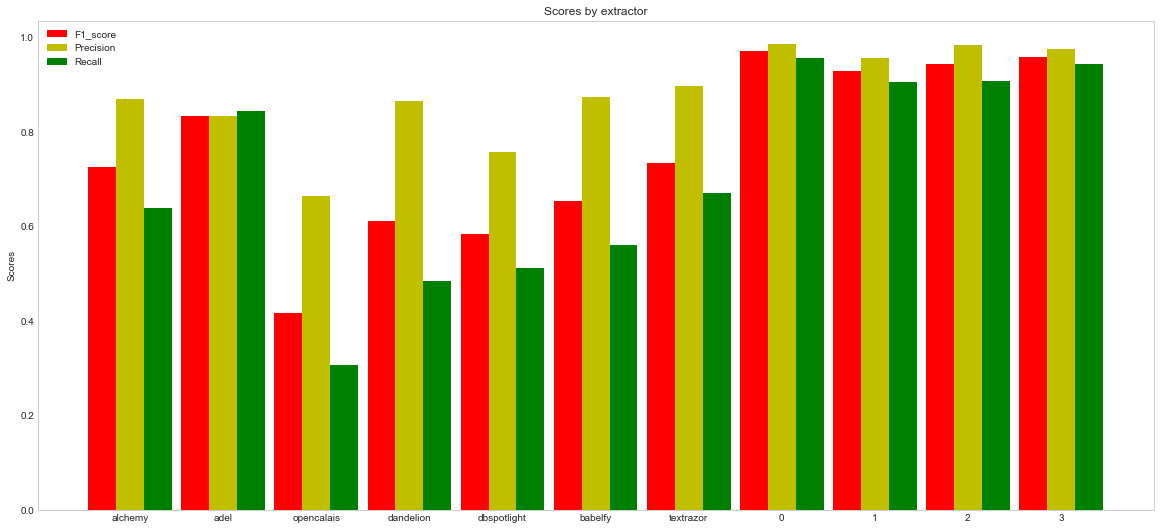

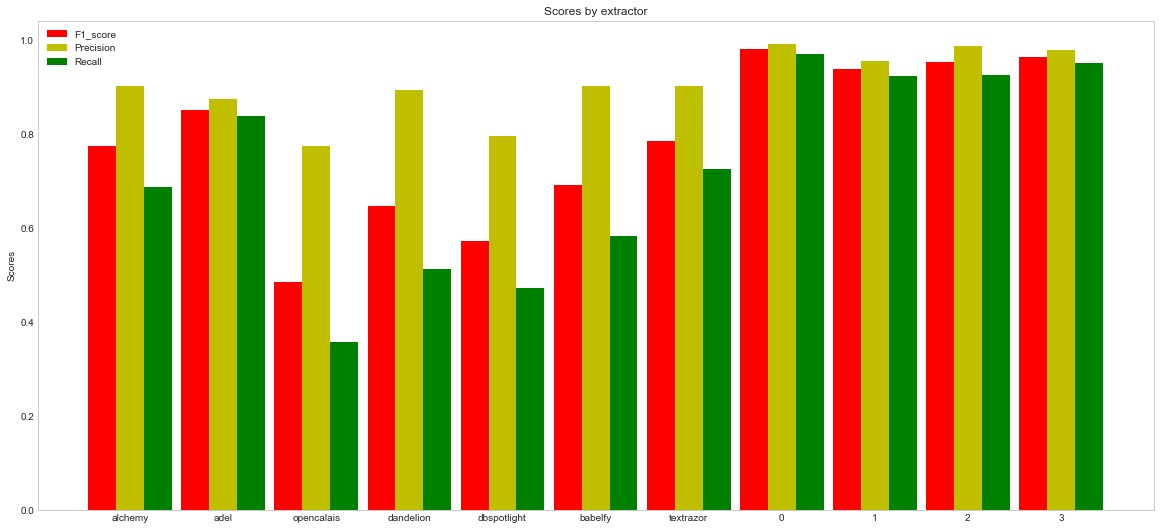

In [262]:
evaluation_df_train= evaluate(evaluation_obj['train'],scores,types,gt_train_flatten,evaluation_folder+'train_')

In [263]:
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

In [264]:
def getTextTokensList(texts_paths):
    texts_splitted_per_file = list()
    for path in texts_paths:
        with open(path) as f:
            texts_splitted_per_file.append(splitInTokens(f.read()))
    return texts_splitted_per_file


def getNamedEntities(type_tokens,offsets,texts_tokens):
    entities = list()
    start_end = list()
    for i,t in enumerate(type_tokens):
        if t != '0':
            start = texts_tokens[i][1]
            end = texts_tokens[i][2]
            if bool(start_end):
                start_end[1] = end
            else:
                start_end = [start,end]
            if bool(offsets[i]):
                pass
            else:
                entities.append({
                    'type':t,
                    'start':start_end[0],
                    'end':start_end[1]
                })
                start_end = []
        else:
            start_end = []
        
    return entities
            
def formBRATandSave(entities,text,output_path):
    BASIC_BRAT_ANN = 'TINDEX\tTYPE START END\tSURFACE'
    brat_lines = list()
    for i,e in enumerate(entities):
        index_ = str(i+1)
        type_ = e['type']
        start_ = str(e['start'])
        end_ = str(e['end']+1)
        text_ = text[e['start']:e['end']+1]
        b_l = BASIC_BRAT_ANN.replace('INDEX',index_).replace('TYPE',type_).replace('START',start_).replace('END',end_).replace('SURFACE',text_)
        brat_lines.append(b_l)
    with open(output_path,'w+') as f_out:
        f_out.write('\n'.join(brat_lines))
        
        
def estimateContinueInfo(predicted):
    offsets = list()
    for j,type_ in enumerate(predicted):
        if type_ == '0':
            offsets.append(0)
        else:
            if j != len(predicted) - 1 and predicted[j+1] == type_:
                offsets.append(1)
            else:
                offsets.append(0)
    return offsets

def addContinueInfo(evaluation_obj):
    for dataset in evaluation_obj:
        for ext in evaluation_obj[dataset]:
            predicted_per_file = evaluation_obj[dataset][ext]['predicted_per_file']
            evaluation_obj[dataset][ext]['offsets'] = [estimateContinueInfo(pred) for pred in predicted_per_file]
    return evaluation_obj

def generateBRATFiles(output_folder,segments_names,texts_paths,offsets_per_file,types_per_file,texts_tokens_per_file):
    for i,t_list in enumerate(types_per_file):
        entities = getNamedEntities(t_list,offsets_per_file[i],texts_tokens_per_file[i])
        text = open(texts_paths[i]).read()
        output_path = output_folder + segments_names[i] + '.ann'
        formBRATandSave(entities,text,output_path)
        


In [265]:
texts_splitted_per_file_test = getTextTokensList(texts_paths_test)
texts_splitted_per_file_train = getTextTokensList(texts_paths_train)

In [266]:
evaluation_obj = addContinueInfo(evaluation_obj)

In [267]:
segments_train = [t.split('/')[-1].split('.')[0] for t in groundtruth_paths_train]
segments_test = [t.split('/')[-1].split('.')[0] for t in groundtruth_paths_test]

In [268]:
brat_truth_folder_train = '/'.join(groundtruth_paths_train[0].split('/')[:-1]).replace('csv_','brat_')+'/'
brat_truth_folder_test = '/'.join(groundtruth_paths_test[0].split('/')[:-1]).replace('csv_','brat_')+'/'
try:
    os.makedirs(brat_truth_folder_train)
except:
    pass
try:
    os.makedirs(brat_truth_folder_test)
except:
    pass

brat_folder = evaluation_folder + 'brat/'


In [269]:
generateBRATFiles(brat_truth_folder_train,
                  segments_train,texts_paths_train,
                  gt_train_offset,gt_train,texts_splitted_per_file_train)
    

In [270]:
generateBRATFiles(brat_truth_folder_test,
                  segments_test,texts_paths_test,
                  gt_test_offset,gt_test,texts_splitted_per_file_test)

In [271]:
for ext in evaluation_obj['test']:
    path = brat_folder+ext+'/test/'
    try:
        os.makedirs(path)
    except:
        pass
    generateBRATFiles(path,
                  segments_test,texts_paths_test,
                  evaluation_obj['test'][ext]['offsets'],
                  evaluation_obj['test'][ext]['predicted_per_file'],texts_splitted_per_file_test)

In [272]:
for ext in evaluation_obj['train']:
    path = brat_folder+ext+'/train/'
    try:
        os.makedirs(path)
    except:
        pass
    generateBRATFiles(path,
                  segments_train,texts_paths_train,
                  evaluation_obj['train'][ext]['offsets'],
                  evaluation_obj['train'][ext]['predicted_per_file'],texts_splitted_per_file_train)

In [4]:
!pip3 install bratutils

  Could not find a version that satisfies the requirement bratutils (from versions: )
No matching distribution found for bratutils


In [3]:
from bratutils import agreement

ModuleNotFoundError: No module named 'bratutils'

In [ ]:
'training_data/OKE2016/evaluation/brat/0/test/document-1.ann'

In [ ]:
'training_data/OKE2016/evaluation/brat/0/train/document-1.ann'

In [ ]:
'training_data/OKE2016/train/brat_ground_trut/document-1.ann'

In [2]:
doc = agreement.Document('training_data/OKE2016/train/brat_ground_truth/document-1.ann')
doc2 = agreement.Document('training_data/OKE2016/evaluation/brat/0/train/document-1.ann')

doc.make_gold()
statistics = doc2.compare_to_gold(doc)

print (statistics)

NameError: name 'agreement' is not defined

In [ ]:
gt_test_offset,gt_test

In [65]:
import importlib
importlib.reload(utils_small)

NameError: name 'utils_small' is not defined

In [1]:
from api_pkg.utils_small import *

In [2]:
splitInTokens('gio e belloo perche')

[('gio', 0, 2), ('e', 4, 4), ('belloo', 6, 11), ('perche', 13, 18)]

In [ ]:
writer = pd.ExcelWriter(path)
fragments = [g.split('/')[-1].split('.')[0] for g in groundtruth_paths]
file_len = [len(t) for t in texts]
i = 0
for k,l in enumerate(file_len):
    records = list()
    for j in range(l):
        obj = {key+' predicted':eval_obj[key]['predicted'][i] for key in eval_obj}
        for key in eval_obj:
            if output in eval_obj[key]:
                obj[key+' output'] = eval_obj[key]['output'][i]
        obj['TEXT'] = texts_flatten[i]
        obj['GROUND TRUTH'] = gt_list[i]
        records.append(obj)
    df = pd.DataFrame(records)
    df.to_excel(writer,fragments[k])
writer.save() 
   
    
writer = pd.ExcelWriter('test_spreadsheets/test.xlsx')
cols = ['text','adel_type', 'alchemy_type','meaning_cloud_type', 'opencalais_type', 'textrazor_type', 'type', 'type_gt']
count = 0

for key in predicted_info:
    count += 1
    df = predicted_info[key][cols]
    df.to_excel(writer,'Sheet'+str(count))
    if count == 1:
        df_test = df
    else:
        df_test = df_test.append(df,ignore_index=True)
writer.save()

In [ ]:
feat = 'uris'
model_obj_path = folder_to_evaluate+feat+'/model_obj.p'
pred_list_test,pred_list_train = getTypesListCombinationfromPath(model_obj_path,gt_test,gt_train)
evaluation_obj['test'][feat]['predicted'] = pred_list_test
evaluation_obj['train'][feat]['predicted'] = pred_list_train
try:
    evaluation_obj['test'][feat]['output'] = getTypeExtractor(ext,features_paths_test,flatten=True)
    evaluation_obj['train'][feat]['output'] = getTypeExtractor(ext,features_paths_train,flatten=True)
except:
    pass
feat = 'fasttext'
model_obj_path = folder_to_evaluate+feat+'/model_obj.p'
pred_list_test,pred_list_train = getTypesListCombinationfromPath(model_obj_path,gt_test,gt_train)
evaluation_obj['test'][feat]['predicted'] = pred_list_test
evaluation_obj['train'][feat]['predicted'] = pred_list_train
try:
    evaluation_obj['test'][feat]['output'] = getTypeExtractor(ext,features_paths_test,flatten=True)
    evaluation_obj['train'][feat]['output'] = getTypeExtractor(ext,features_paths_train,flatten=True)
except:
    pass

In [182]:
TEXT = open('training_data/OKE2016/train/txt_files/document-170.txt').read()
#brat_ground_trut

In [197]:
l = splitInTokens(TEXT)

In [196]:
sss = """0,1,0,albert,Person,oke:Albert_Modiano,
0,0,0,modiano,Person,oke:Albert_Modiano,
0,0,0,(,,,
0,0,0,1912–77,,,
0,0,0,",",,,
0,0,0,born,,,
0,0,0,in,,,
0,0,0,paris,Place,http://dbpedia.org/resource/Paris,Q90
0,0,0,),,,
0,0,0,",",,,
0,0,0,was,,,
0,0,0,of,,,
0,0,0,italian,,,
0,0,0,jewish,,,
0,0,0,origin,,,
0,0,0,;,,,
0,0,0,on,,,
0,0,0,his,Person,oke:Albert_Modiano,
0,0,0,paternal,,,
0,0,0,side,,,
0,0,0,he,Person,oke:Albert_Modiano,
0,0,0,was,,,
0,0,0,descended,,,
0,0,0,from,,,
0,0,0,a,,,
0,1,0,sephardic,Organization,oke:Sephardi_family,
0,0,0,family,Organization,oke:Sephardi_family,
0,0,0,of,,,
0,1,0,thessaloniki,Place,http://dbpedia.org/resource/Thessaloniki,Q17151
0,1,0,",",Place,http://dbpedia.org/resource/Thessaloniki,Q17151
0,0,0,greece,Place,http://dbpedia.org/resource/Thessaloniki,Q17151
0,0,0,.,,,
0,0,0,his,Person,oke:Albert_Modiano,
0,0,0,mother,Role,http://dbpedia.org/resource/Mother,Q7560
0,0,0,",",,,
0,1,0,louisa,Person,oke:Louisa_Colpijn,
0,0,0,colpijn,Person,oke:Louisa_Colpijn,
0,0,0,(,,,
0,0,0,1918,,,
0,0,0,-,,,
0,0,0,2015,,,
0,0,0,),,,
0,0,0,",",,,
0,0,0,was,,,
0,0,0,an,,,
0,0,0,actress,Role,http://dbpedia.org/resource/Actor,Q33999
0,0,0,also,,,
0,0,0,known,,,
0,0,0,as,,,
0,1,0,louisa,Person,oke:Louisa_Colpeyn,
0,0,0,colpeyn,Person,oke:Louisa_Colpeyn,
0,0,0,.,,,
"""
print([l[3] for l in [k.split(',') for k in sss.split('\n') if len(k.split(',')) > 3]])

['albert', 'modiano', '(', '1912–77', '"', 'born', 'in', 'paris', ')', '"', 'was', 'of', 'italian', 'jewish', 'origin', ';', 'on', 'his', 'paternal', 'side', 'he', 'was', 'descended', 'from', 'a', 'sephardic', 'family', 'of', 'thessaloniki', '"', 'greece', '.', 'his', 'mother', '"', 'louisa', 'colpijn', '(', '1918', '-', '2015', ')', '"', 'was', 'an', 'actress', 'also', 'known', 'as', 'louisa', 'colpeyn', '.']


In [199]:
print([v[0] for v in l])

['albert', 'modiano', '(', '1912–77', ',', 'born', 'in', 'paris', '),', 'was', 'of', 'italian', 'jewish', 'origin', ';', 'on', 'his', 'paternal', 'side', 'he', 'was', 'descended', 'from', 'a', 'sephardic', 'family', 'of', 'thessaloniki', ',', 'greece', '.', 'his', 'mother', ',', 'louisa', 'colpijn', '(', '1918', '-', '2015', '),', 'was', 'an', 'actress', 'also', 'known', 'as', 'louisa', 'colpeyn', '.']


[('albert', 0, 5),
 ('modiano', 7, 13),
 ('(', 15, 15),
 ('1912–77', 16, 22),
 (',', 23, 23),
 ('born', 25, 28),
 ('in', 30, 31),
 ('paris', 33, 37),
 ('),', 38, 39),
 ('was', 41, 43),
 ('of', 45, 46),
 ('italian', 48, 54),
 ('jewish', 56, 61),
 ('origin', 63, 68),
 (';', 69, 69),
 ('on', 71, 72),
 ('his', 74, 76),
 ('paternal', 78, 85),
 ('side', 87, 90),
 ('he', 92, 93),
 ('was', 95, 97),
 ('descended', 99, 107),
 ('from', 109, 112),
 ('a', 114, 114),
 ('sephardic', 116, 124),
 ('family', 126, 131),
 ('of', 133, 134),
 ('thessaloniki', 136, 147),
 (',', 148, 148),
 ('greece', 150, 155),
 ('.', 156, 156),
 ('his', 158, 160),
 ('mother', 162, 167),
 (',', 168, 168),
 ('louisa', 170, 175),
 ('colpijn', 177, 183),
 ('(', 185, 185),
 ('1918', 186, 189),
 ('-', 190, 190),
 ('2015', 191, 194),
 ('),', 195, 196),
 ('was', 198, 200),
 ('an', 202, 203),
 ('actress', 205, 211),
 ('also', 213, 216),
 ('known', 218, 222),
 ('as', 224, 225),
 ('louisa', 227, 232),
 ('colpeyn', 234, 240),
 ('.', 24

In [202]:
splitInTokens(TEXT)

[('albert', 0, 5),
 ('modiano', 7, 13),
 ('(', 15, 15),
 ('1912–77', 16, 22),
 (',', 23, 23),
 ('born', 25, 28),
 ('in', 30, 31),
 ('paris', 33, 37),
 (')', 38, 38),
 (',', 39, 39),
 ('was', 41, 43),
 ('of', 45, 46),
 ('italian', 48, 54),
 ('jewish', 56, 61),
 ('origin', 63, 68),
 (';', 69, 69),
 ('on', 71, 72),
 ('his', 74, 76),
 ('paternal', 78, 85),
 ('side', 87, 90),
 ('he', 92, 93),
 ('was', 95, 97),
 ('descended', 99, 107),
 ('from', 109, 112),
 ('a', 114, 114),
 ('sephardic', 116, 124),
 ('family', 126, 131),
 ('of', 133, 134),
 ('thessaloniki', 136, 147),
 (',', 148, 148),
 ('greece', 150, 155),
 ('.', 156, 156),
 ('his', 158, 160),
 ('mother', 162, 167),
 (',', 168, 168),
 ('louisa', 170, 175),
 ('colpijn', 177, 183),
 ('(', 185, 185),
 ('1918', 186, 189),
 ('-', 190, 190),
 ('2015', 191, 194),
 (')', 195, 195),
 (',', 196, 196),
 ('was', 198, 200),
 ('an', 202, 203),
 ('actress', 205, 211),
 ('also', 213, 216),
 ('known', 218, 222),
 ('as', 224, 225),
 ('louisa', 227, 232),
 

In [156]:
splitting_chars

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 ' ',
 '\t',
 '\n',
 '\r',
 '\x0b',
 '\x0c']

In [201]:
len(splitInTokens(TEXT))

52

In [161]:
TEXT

"Gunter Pauli is a graduate from Loyola's University in Belgium, Economics and obtained his MBA from INSEAD in Fontainebleau, France."

In [118]:
len(removeSplittingChars(l))

t
a
ș
a
s
l


27

In [126]:
def removeSplittingChars(tokens):
    new_tokens = list()
    for t in tokens:
        new_token = deepcopy(t)
        additional_tokens = list()
        text = new_token[0]
        while text[0] in splitting_chars:
            add_t = (text[0],new_token[1],new_token[1])
            additional_tokens.append(add_t)
            new_token = (text[1:],new_token[1]+1,new_token[2])
            text = new_token[0]
        while text[-1] in splitting_chars:
            add_t = (text[-1],new_token[2],new_token[2])
            additional_tokens.append(add_t)
            new_token = (text[:-1],new_token[1],new_token[2]-1)
            text = new_token[0]
        new_tokens += [new_token]+additional_tokens
    return new_tokens
            

In [ ]:
final_tuples = [(m.group(0), m.start(),m.start()+len(m.group(0))-1) for m in re.finditer(r'\S+', s)]

In [93]:
for t in tokens:
    

','

In [168]:
splitting_chars[:-6]

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [167]:
for t in splitting_chars[:-6]:
    print(t)

In [200]:
def splitInTokens(string):
    s=string.lower()
    final_tuples = ([(m.group(0), m.start(),m.start()+len(m.group(0))-1)
                    for m in re.finditer(re.compile('[^'+''.join(splitting_chars)+']+')
                                         , s)]
                    +
                    [(m.group(0), m.start(),m.start()+len(m.group(0))-1)
                    for m in re.finditer(re.compile('['+''.join(splitting_chars[:-6])+']')
                                         , s)]
    )
    final_tuples.sort(key=lambda x:x[1])
    return final_tuples

In [121]:
def formatText(string,lower=True):
    if lower:
        string = string.lower()
    for ch in splitting_chars:
        if ch != ' ':
            string = string.replace(ch,' '+ch+' ')
    return string.replace('  ',' ')

In [ ]:
pos:4
act:4
cor:4
par:0
inc:0
mis:0
spu:0
------------------------------------------------
pre:1.0
rec:1.0
fsc:1.0
------------------------------------------------
und:0.0
ovg:0.0
sub:0.0
------------------------------------------------
bor:4
ibo:0